In [1]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 25 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 5
cfg['set_id'] = 2

In [2]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [3]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [4]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [5]:
from dataloader import *
from models import *
import time

model = GRU_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [6]:
model.train()

GRU_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (gru): GRU(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 2.55641
count = 4, loss = 1.15407
count = 6, loss = 0.69270
count = 8, loss = 0.34188
count = 10, loss = 0.27941
count = 12, loss = 0.32481
count = 14, loss = 0.28804
validation loss: 0.21430512368679047
epoch finished: 1
count = 2, loss = 0.27403
count = 4, loss = 0.30213
count = 6, loss = 0.30414
count = 8, loss = 0.33047
count = 10, loss = 0.28929
count = 12, loss = 0.29066
count = 14, loss = 0.25277
validation loss: 0.22047629058361054
epoch finished: 2
count = 2, loss = 0.29572
count = 4, loss = 0.28814
count = 6, loss = 0.26649
count = 8, loss = 0.29882
count = 10, loss = 0.30608
count = 12, loss = 0.26384
count = 14, loss = 0.29855
validation loss: 0.20881664454936982
epoch finished: 3
count = 2, loss = 0.28512
count = 4, loss = 0.26962
count = 6, loss = 0.29100
count = 8, loss = 0.25778
count = 10, loss = 0.31841
count = 12, loss = 0.28854
count = 14, loss = 0.30131
validation loss: 0.23406370878219604
epoch finished: 4
count = 2, loss = 0.23008
count = 4, los

In [8]:
np.save('val_loss_gru_set2.npy', val_losses)
np.save('train_loss_gru_set2.npy', train_losses)

In [32]:
model = load_model(LSTM_Score, './models/s2_ba120e25b14.pt', cfg)
valid_indices = list(range(len(valid_data)))

In [10]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 0.2947779715061188
validation MAE: 0.08775311857461929
QWK Score: 0.6096970104809812


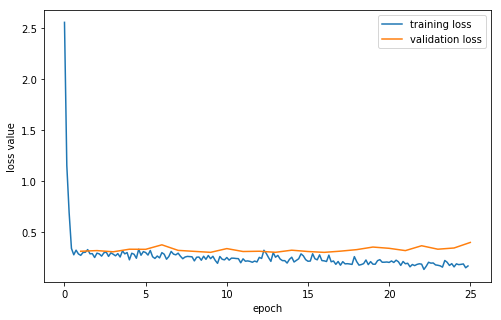

In [16]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses)+0.1,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [12]:
targets

[array([2, 2, 3, 2, 4, 2, 3, 1, 3, 2, 2, 1, 2, 3, 2, 1, 2, 1, 2, 2, 3, 2,
        4, 1, 3, 3, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 4, 2, 2, 3, 3, 1, 2, 4,
        3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 1, 3, 2,
        3, 3, 2, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 2, 3,
        2, 2, 3, 2, 2, 2, 2, 2, 3, 4, 3, 2, 1, 3, 3, 2, 2, 2, 2, 4, 2, 2,
        2, 2, 3, 2, 2, 3, 3, 3, 2, 3]),
 array([2, 2, 3, 3, 1, 3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2,
        2, 3, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 1, 3, 2, 2, 3, 3, 3, 3, 2, 3,
        4, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2,
        3, 2, 3, 1, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 0, 3, 3, 2, 3, 3, 2, 3,
        2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 4, 2, 3, 1, 3, 2, 3, 2, 3, 2,
        2, 2, 2, 2, 2, 3, 2, 2, 3, 3]),
 array([2, 2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2,
        2, 3, 3, 2, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2,
        3, 2, 2, 2, 1, 3, 3, 2, 

In [13]:
preds

[array([3, 2, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 2, 1, 2, 2, 2, 2,
        3, 1, 3, 3, 2, 2, 3, 2, 2, 4, 3, 2, 3, 2, 4, 2, 2, 2, 3, 1, 3, 4,
        3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 1, 2, 2,
        2, 2, 2, 3, 2, 3, 3, 2, 3, 1, 4, 3, 2, 2, 1, 2, 4, 3, 3, 3, 2, 2,
        2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 4, 3, 2,
        2, 4, 2, 2, 3, 3, 2, 3, 3, 2]),
 array([2, 2, 3, 2, 1, 3, 2, 3, 2, 3, 3, 2, 1, 2, 3, 2, 2, 2, 2, 3, 2, 2,
        2, 3, 2, 3, 3, 1, 2, 3, 1, 2, 2, 3, 2, 3, 2, 2, 3, 3, 4, 3, 2, 3,
        3, 2, 2, 3, 1, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 4, 2,
        3, 2, 3, 1, 2, 1, 3, 2, 3, 2, 3, 3, 3, 3, 1, 2, 2, 2, 3, 3, 3, 4,
        2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 4, 3, 3, 1, 3, 2, 2, 1, 2, 4,
        2, 3, 3, 2, 3, 3, 2, 2, 3, 3]),
 array([2, 2, 3, 2, 3, 1, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 2, 3, 1,
        2, 4, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 4, 4, 3, 2, 1, 3,
        3, 2, 3, 3, 1, 3, 3, 3, 

In [14]:
train_losses

[2.5564105808734894,
 1.1540706753730774,
 0.6927004456520081,
 0.34188465774059296,
 0.27941370010375977,
 0.3248053342103958,
 0.28804080188274384,
 0.2740340530872345,
 0.30212827026844025,
 0.30413636565208435,
 0.3304698169231415,
 0.289294958114624,
 0.290656253695488,
 0.25277189910411835,
 0.29572397470474243,
 0.2881357669830322,
 0.2664944678544998,
 0.2988210618495941,
 0.306078165769577,
 0.26383598148822784,
 0.29855410754680634,
 0.2851152718067169,
 0.26962217688560486,
 0.29100431501865387,
 0.2577790096402168,
 0.3184128701686859,
 0.28854334354400635,
 0.3013131320476532,
 0.23007700592279434,
 0.29457593709230423,
 0.2847297713160515,
 0.2455163225531578,
 0.33389921486377716,
 0.2750457227230072,
 0.310469388961792,
 0.3016803562641144,
 0.2767600640654564,
 0.32160714268684387,
 0.2602667286992073,
 0.24364934116601944,
 0.26741915941238403,
 0.24903620034456253,
 0.30053164064884186,
 0.284857340157032,
 0.23604042828083038,
 0.2626693546772003,
 0.312544375658035

In [15]:
val_losses

[0.21430512368679047,
 0.22047629058361054,
 0.20881664454936982,
 0.23406370878219604,
 0.23294867873191832,
 0.27716468572616576,
 0.2227083057165146,
 0.21295123994350434,
 0.20344589352607728,
 0.2402271181344986,
 0.21155256032943726,
 0.21421803236007692,
 0.20391554534435272,
 0.2245348572731018,
 0.21153998374938965,
 0.20326873660087585,
 0.2150765150785446,
 0.2300035297870636,
 0.25525871813297274,
 0.24290763437747956,
 0.22039334177970887,
 0.26807174980640414,
 0.23423410952091217,
 0.24607832133769988,
 0.3005083680152893]